## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#Project 5
#Marisa Tsai
#Spring 2024

In [2]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# load data 
# ----------
congress_tweets = pd.read_csv("/Users/marisatsai/Downloads/data 2/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(1_000)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
179232,1.192820e+18,RepJohnLarson,2019-11-08T09:51:47-05:00,Wishing @radioviceonline the best! Looking for...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
495859,1.121510e+18,SenatorShaheen,2019-04-25T16:14:52-04:00,Please join me tomorrow at 6:15pm in Berlin fo...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918"
818005,1.273310e+18,JohnCornyn,2020-06-17T13:41:58-04:00,RT @SenatorTimScott Y’all still wearing those ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
786850,1.185220e+18,JacksonLeeTX18,2019-10-18T11:47:17-04:00,"RT @SenWhitehouse The choice Trump gave: ""aban...",Sheila Jackson Lee,Rep,3-Jan-95,1/12/1950,F,TX,18,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
548703,1.080880e+18,NitaLowey,2019-01-03T12:17:30-05:00,RT @NancyPelosi As the House of Representative...,Nita Lowey,Rep,3-Jan-89,7/5/1937,F,NY,17,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [5]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
179232,1.192820e+18,RepJohnLarson,2019-11-08T09:51:47-05:00,Wishing @radioviceonline the best! Looking for...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
495859,1.121510e+18,SenatorShaheen,2019-04-25T16:14:52-04:00,Please join me tomorrow at 6:15pm in Berlin fo...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918"
818005,1.273310e+18,JohnCornyn,2020-06-17T13:41:58-04:00,RT @SenatorTimScott Y’all still wearing those ...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
786850,1.185220e+18,JacksonLeeTX18,2019-10-18T11:47:17-04:00,"RT @SenWhitehouse The choice Trump gave: ""aban...",Sheila Jackson Lee,Rep,3-Jan-95,1/12/1950,F,TX,18,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
548703,1.080880e+18,NitaLowey,2019-01-03T12:17:30-05:00,RT @NancyPelosi As the House of Representative...,Nita Lowey,Rep,3-Jan-89,7/5/1937,F,NY,17,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [6]:
#word frequencies
# load libraries
# ----------
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


In [7]:
# initalize CountVectorizer and specify some parameters
# ----------
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, # use our function for tokenizing created above
                             token_pattern = None,      # set to "None" since we have specify our own pattern
                             ngram_range=(1,1))         # use default for unigrams - see documentation

In [8]:
# fit and transform just a subset of our data
# ----------
bow_matrix = bow_vector.fit_transform(congress_tweets['text'][0:]) 

In [9]:
# visualize
# ----------
bow_matrix.todense() # todense() densifies the sparse matrix (which only stores non-zeros elements)

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# get feature names instead and view subset
# ----------
feature_names = bow_vector.get_feature_names_out()
feature_names[0:10] 

array(['\n', '\n\n', '\n\n ', '\n\n    ', '\n ', '\n \n', '\n    \n',
       '\n     ', '\n\xa0\n', ' '], dtype=object)

In [11]:
# Code to concatenate bag of words matrix with column names to visualize
# ----------
bow_df = pd.DataFrame(bow_matrix.toarray(),  # make bow_matrix an array 
                      columns=feature_names) # set column names to feature names just extracted
bow_df

,\n,\n\n,\n\n,\n\n,\n,\n \n,\n \n,\n,\n \n,,...,🗳,😂,😧,😲,🙌,🚒,🚨,🛩,🤷,🧡
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EDA 2

In [12]:
#word cloud
# download libraries
# ----------
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob

In [13]:
# load libraries
# ----------
import pandas as pd
import numpy as np

from PIL import Image
import spacy
import en_core_web_sm

In [14]:
#this causes kernal to die but not needed right now 
#import scattertext as st
#nlp = en_core_web_sm.load()

In [15]:
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# code for kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# settings 
%matplotlib inline

In [17]:
from collections import Counter
# Counter(' '.join(congress_tweets['text'].map(lambda text: text.split()).explode()).split())

In [18]:
import pandas as pd

def check_word(word, stop_words):
    word = word.lower()
    if word in stop_words:
        return False
    if word.startswith("https"):
        return False
    if word.endswith("jpg") or word.endswith("jpeg"):
        return False
    return True

# Assuming you have a DataFrame named 'df' with a column named 'text_column'
# containing the text data where you want to remove stop words

# Define your remove_stop_words function
def remove_stop_words(text, stop_words):
    """
    Removes stop words from the input text.

    Args:
    text (str): The input text.
    stop_words (list): A list of stop words to be removed from the text.

    Returns:
    str: The text with stop words removed.
    """
    words = text.split()
    filtered_words = [word for word in words if check_word(word, stop_words)]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# List of stop words
stop_words = ["rt", "qt", "twimg", "amp", "jpg", "https", "&amp;"]

# Apply remove_stop_words function to 'text_column' in the DataFrame
congress_tweets['text'] = congress_tweets['text'].apply(lambda x: remove_stop_words(x, stop_words))

# Display the modified DataFrame
print(congress_tweets['text'])
# remove_stop_words(congress_tweets['text'].iloc[0], stop_words)

179232    Wishing @radioviceonline the best! Looking for...
495859    Please join me tomorrow at 6:15pm in Berlin fo...
818005    @SenatorTimScott Y’all still wearing those ken...
786850    @SenWhitehouse The choice Trump gave: "abandon...
548703    @NancyPelosi As the House of Representatives o...
                                ...                        
302420    @AmericasVoice .@SenatorDurbin: "It is a high ...
389337    .@McDonaldsCorp is the first global restaurant...
198075    Federal workers are struggling to feed their f...
86118     Congrats to the @RiverCats! Making Sacramento ...
227069    @HouseIntel "Mr. Giuliani became an inescapabl...
Name: text, Length: 1000, dtype: object


In [19]:
# ----------
# congress_tweets = pd.read_csv("/Users/marisatsai/Downloads/data 2/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
# congress_tweets = congress_tweets.sample(10000)

In [20]:
# Convert rows of tweets to rows of individual words in each tweet
words = congress_tweets['text'].map(lambda text: text.split()).explode()
# Filter null rows
words = words[~words.isnull()]
# Form single space-separated string from all the remaining words
text = ' '.join(words)

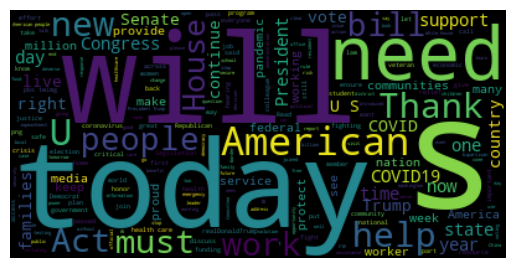

In [21]:
# create WordCloud visualization using the "text" object 
# not sure why stop words are still being included 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [22]:
# load data 
# ----------
#congress_tweets = pd.read_csv("/Users/marisatsai/Downloads/data 2/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
# congress_tweets = congress_tweets.sample(10_000)
# congress_tweets.head()

In [23]:
congress_tweets.groupby("name_wikipedia").count()["tweet_id"].sort_values()[-25:]

name_wikipedia
Tom Carper                 6
Mark E. Green              6
Val Demings                7
Carolyn Maloney            7
Suzanne Bonamici           7
Jeff Merkley               7
Sylvia Garcia              7
Jeanne Shaheen             7
Mitch McConnell            7
Lloyd Doggett              8
Ted Cruz                   8
Jim Banks                  8
Debbie Mucarsel-Powell     8
Kathy Castor               8
Chuck Schumer              8
Chris Coons                8
Bill Pascrell              9
Ro Khanna                  9
Steny Hoyer                9
Susie Lee                 10
Pramila Jayapal           10
Dwight Evans              12
Andy Biggs                13
Don Beyer                 18
John Cornyn               20
Name: tweet_id, dtype: int64

In [24]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "text" column again 
# congress_tweets['text'] = congress_tweets['text'].map(lambda text: ' '.join(text))

# create the "text" column again 
congress_tweets['polarity'] = congress_tweets['text'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
congress_tweets.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,polarity
179232,1.192820e+18,RepJohnLarson,2019-11-08T09:51:47-05:00,Wishing @radioviceonline the best! Looking for...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",0.483333
495859,1.121510e+18,SenatorShaheen,2019-04-25T16:14:52-04:00,Please join me tomorrow at 6:15pm in Berlin fo...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918",0.000000
818005,1.273310e+18,JohnCornyn,2020-06-17T13:41:58-04:00,@SenatorTimScott Y’all still wearing those ken...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",-0.208333
786850,1.185220e+18,JacksonLeeTX18,2019-10-18T11:47:17-04:00,"@SenWhitehouse The choice Trump gave: ""abandon...",Sheila Jackson Lee,Rep,3-Jan-95,1/12/1950,F,TX,18,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",-0.041667
548703,1.080880e+18,NitaLowey,2019-01-03T12:17:30-05:00,@NancyPelosi As the House of Representatives o...,Nita Lowey,Rep,3-Jan-89,7/5/1937,F,NY,17,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269724,1.230230e+18,RepRussFulcher,2020-02-19T15:22:57-05:00,"...As I have previously said, economic indicat...",Russ Fulcher,Rep,3-Jan-19,7/19/1973,M,ID,1,Republican,"409,055","189,765","212,787","420,911",0.155556
333475,1.250830e+18,SenJoniErnst,2020-04-16T12:45:25-04:00,Beating #COVID19 is going to take all of us—at...,Joni Ernst,Sen,3-Jan-19,7/1/1970,F,IA,Senate,Republican,"800,983","653,669","822,544","730,617",0.000000
225850,1.214690e+18,RepMichaelWaltz,2020-01-07T18:42:33-05:00,President @realDonaldTrump has made the right ...,Michael Waltz,Rep,3-Jan-19,1/31/1974,M,FL,6,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",0.196429
617132,1.248360e+18,RepDavidRouzer,2020-04-09T17:20:09-04:00,@ncdhhs Stay as healthy as possible to reduce ...,David Rouzer,Rep,3-Jan-15,2/16/1972,M,NC,7,Republican,"2,362,631","2,189,316","2,178,391","2,270,395",0.089143


In [25]:
np.sum(congress_tweets['name_wikipedia'] == 'Nancy Pelosi')

5

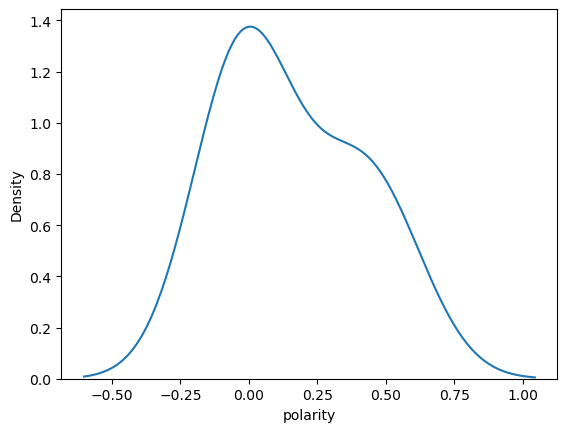

In [26]:
NancyPelosi_data = congress_tweets[congress_tweets['name_wikipedia'] == 'Nancy Pelosi']

sns.kdeplot(NancyPelosi_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

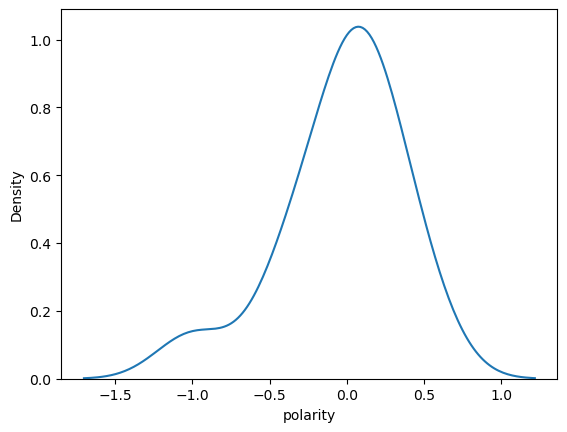

In [27]:
AndyBiggs_data = congress_tweets[congress_tweets['name_wikipedia'] == 'Andy Biggs']

sns.kdeplot(AndyBiggs_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

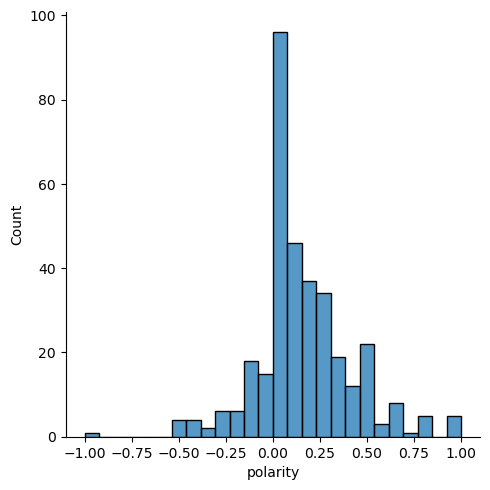

In [28]:
Rep_data = congress_tweets[congress_tweets['party'] == 'Republican']

#histogram
sns.displot(Rep_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

In [29]:
Rep_data.head(100)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,polarity
818005,1.273310e+18,JohnCornyn,2020-06-17T13:41:58-04:00,@SenatorTimScott Y’all still wearing those ken...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",-0.208333
206643,1.124740e+18,SenRubioPress,2019-05-04T14:15:12-04:00,The U.S. recognizes Interim President @jguaido...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,FL,Senate,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",0.000000
624603,1.220210e+18,RepArmstrongND,2020-01-22T23:59:42-05:00,@RepLeeZeldin Schiff and his crew can say “no ...,Kelly Armstrong,Rep,3-Jan-19,10/8/1976,M,ND,0,Republican,"216,794","93,758","124,827","188,163",0.166667
797830,1.220300e+18,JohnCornyn,2020-01-23T06:18:00-05:00,"@dcexaminer ""I hope this isn't just going to b...",John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",0.099026
316857,1.153380e+18,RepJimBanks,2019-07-22T14:46:18-04:00,Fiscally responsible legislators will have a t...,Jim Banks,Rep,3-Jan-17,7/16/1979,M,IN,3,Republican,"1,557,286","1,033,126","1,152,887","1,420,543",0.043519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228677,1.224880e+18,RepRutherfordFL,2020-02-04T21:12:44-05:00,"Under @realDonaldTrump's leadership, we secure...",John Rutherford,Rep,3-Jan-17,9/2/1952,M,FL,4,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",0.256061
654167,1.339690e+18,RepBradWenstrup,2020-12-17T17:11:59-05:00,🚨The Vaccines and Related Biological Products ...,Brad Wenstrup,Rep,3-Jan-13,6/17/1958,M,OH,2,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",0.221429
793176,1.204470e+18,RepArrington,2019-12-10T13:51:50-05:00,“Between his work on the Ways and Means Commit...,Jodey Arrington,Rep,3-Jan-17,3/9/1972,M,TX,19,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",-0.182292
221474,1.194660e+18,RepGusBilirakis,2019-11-13T11:52:27-05:00,"... health professionals, and authorizes grant...",Gus Bilirakis,Rep,3-Jan-07,2/8/1963,M,FL,12,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",0.388889


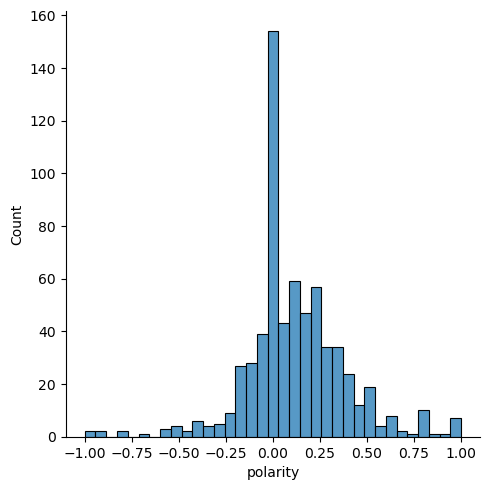

In [30]:
Dem_data = congress_tweets[congress_tweets['party'] == 'Democrat']

#histogram
sns.displot(Dem_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

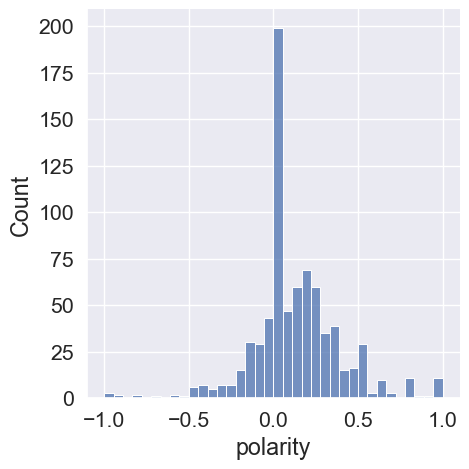

In [200]:
Repr_data = congress_tweets[congress_tweets['position'] == 'Rep']

#histogram
sns.displot(Repr_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

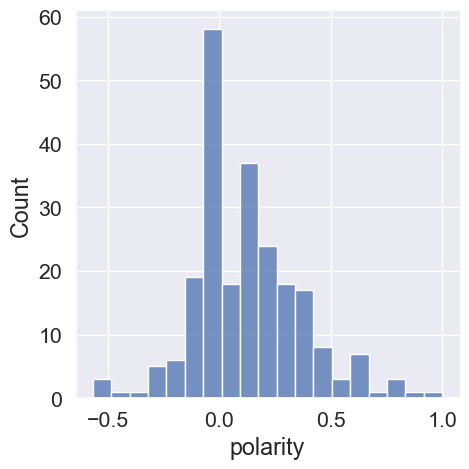

In [201]:
Sen_data = congress_tweets[congress_tweets['position'] == 'Sen']

#histogram
sns.displot(Sen_data,         # specify data
            x="polarity") # x-axis label 
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [32]:
# Engineered Features

# find the character count for each document 
# --------
# apply length function to tokens column to count each character
congress_tweets['tweet_len'] = congress_tweets['text'].apply(len)

# view the new feature we just created
congress_tweets[['text', 'tweet_len']]

,text,tweet_len
179232,Wishing @radioviceonline the best! Looking for...,337
495859,Please join me tomorrow at 6:15pm in Berlin fo...,168
818005,@SenatorTimScott Y’all still wearing those ken...,236
786850,"@SenWhitehouse The choice Trump gave: ""abandon...",247
548703,@NancyPelosi As the House of Representatives o...,164
...,...,...
302420,"@AmericasVoice .@SenatorDurbin: ""It is a high ...",192
389337,.@McDonaldsCorp is the first global restaurant...,270
198075,Federal workers are struggling to feed their f...,319
86118,Congrats to the @RiverCats! Making Sacramento ...,68


In [33]:
# find the word count for each document 
# --------
# apply length function to tokens column to count words -- you will need to split the text to count words
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

# view
congress_tweets[['text', 'tweet_len', 'word_count']]

,text,tweet_len,word_count
179232,Wishing @radioviceonline the best! Looking for...,337,50
495859,Please join me tomorrow at 6:15pm in Berlin fo...,168,27
818005,@SenatorTimScott Y’all still wearing those ken...,236,34
786850,"@SenWhitehouse The choice Trump gave: ""abandon...",247,36
548703,@NancyPelosi As the House of Representatives o...,164,28
...,...,...,...
302420,"@AmericasVoice .@SenatorDurbin: ""It is a high ...",192,31
389337,.@McDonaldsCorp is the first global restaurant...,270,43
198075,Federal workers are struggling to feed their f...,319,34
86118,Congrats to the @RiverCats! Making Sacramento ...,68,9


### Bag-of-words or Tf-idf

In [34]:
from spacy.lang.en.stop_words import STOP_WORDS

In [35]:
#congress_tweets = pd.read_csv("/Users/marisatsai/Downloads/data 2/116th Congressional Tweets and Demographics.csv")
#congress_tweets = congress_tweets.sample(10000)

In [36]:
# Frequency Based featurization

# initialize the Bag-of-Words CounterVectorizer
# ----------
# notice the ngram_range argument
countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(2,3))

In [37]:
# fit and transform on tokens
ngrams = countvec.fit_transform(congress_tweets['text'])         

# create a dataframe out of ngram sparse matrix - need to densify bc DataFrame can't handle sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # specify data to convert to dataframe 
                                    columns = countvec.get_feature_names_out()) # get features

/Users/marisatsai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


### Word Embedding

In [38]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('/Users/marisatsai/Downloads/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [39]:
# embedding based featurization
...# create preprocessing function 
# ----------

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # Using the bitwise |= (or) operator
    nlp.Defaults.stop_words |= {"xx", "xxxx","xxxxxxxx"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [40]:
# apply our preprocessing function 
# ----------
congress_tweets['text'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['text']

179232    [wishing, radioviceonline, best, looking, forw...
495859    [join, tomorrow, 615pm, berlin, town, hall, me...
818005    [senatortimscott, y’all, wearing, kente, cloth...
786850    [senwhitehouse, choice, trump, gave, abandon, ...
548703    [nancypelosi, house, representatives, opens, 1...
                                ...                        
302420    [americasvoice, senatordurbin, high, standard,...
389337    [mcdonaldscorp, global, restaurant, use, scien...
198075    [federal, workers, struggling, feed, families,...
86118     [congrats, rivercats, making, sacramento, prou...
227069    [houseintel, mr, giuliani, inescapable, presen...
Name: text, Length: 1000, dtype: object

In [41]:
# apply CBOW Word2vec model
# ----------
model = gensim.models.Word2Vec(congress_tweets['text'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [42]:
help(model.build_vocab_from_freq)

Help on method build_vocab_from_freq in module gensim.models.word2vec:

build_vocab_from_freq(word_freq, keep_raw_vocab=False, corpus_count=None, trim_rule=None, update=False) method of gensim.models.word2vec.Word2Vec instance
    Build vocabulary from a dictionary of word frequencies.
    
    Parameters
    ----------
    word_freq : dict of (str, int)
        A mapping from a word in the vocabulary to its frequency count.
    keep_raw_vocab : bool, optional
        If False, delete the raw vocabulary after the scaling is done to free up RAM.
    corpus_count : int, optional
        Even if no corpus is provided, this argument can set corpus_count explicitly.
    trim_rule : function, optional
        Vocabulary trimming rule, specifies whether certain words should remain in the vocabulary,
        be trimmed away, or handled using the default (discard if word count < min_count).
        Can be None (min_count will be used, look to :func:`~gensim.utils.keep_vocab_item`),
        or a

In [43]:
# return embeddings for specific word
# ----------
print(model.wv.__getitem__(['year'])) # specify a key word here: ""

[[-0.01318546  0.02783315  0.01340942 -0.00382068  0.01202022 -0.05561549
   0.01169064  0.07586628 -0.02637906 -0.0080167  -0.03391568 -0.02606788
  -0.01189748 -0.00326254  0.0059909  -0.00462999  0.01263532 -0.03974244
  -0.00615811 -0.07438418  0.00869141  0.02380959  0.00339613 -0.01117054
  -0.01592935  0.00553082 -0.03410446 -0.01986314 -0.01634517  0.00908724
   0.02966411  0.01851878 -0.00562356 -0.01746101 -0.01990131  0.03450157
  -0.01014775 -0.03663355 -0.01947243 -0.06318903 -0.00691464 -0.02829033
   0.00693541  0.00310044  0.03116989 -0.00290928 -0.02810055  0.00449642
   0.01949962  0.02706609  0.01000388 -0.03131289  0.00348805  0.00519795
  -0.03979729  0.02655304  0.01960305  0.0073751  -0.04755723  0.01472323
   0.00833756  0.00580034 -0.01184223 -0.01202062 -0.03530274  0.01960455
   0.03297684  0.03758803 -0.04470145  0.03082082 -0.02342875  0.00463678
   0.0356028   0.00014209  0.03135657  0.02269055 -0.01802182 -0.00372097
  -0.02370892  0.01220184 -0.01730068 

In [44]:
# get shape
# ----------
model.wv.__getitem__(['year']).shape 

(1, 100)

In [45]:
# get length
# ----------
len(congress_tweets['text'].iloc[0])


27

In [46]:
# get model's vocabulary
# ----------
doc = [word for word in congress_tweets['text'].iloc[0] if word in model.wv.index_to_key]
len(doc)

9

In [47]:
# look at the first five
# ----------
doc[0:5]

['wishing', 'best', 'looking', 'forward', 'coming']

In [48]:
# word embeddings for "new"
# ----------
print(model.wv['new'])
print(model.wv['new'].shape)

[-0.02881349  0.04189992  0.03299482 -0.00654757  0.03334083 -0.07824776
  0.01738886  0.12884468 -0.02680385 -0.0209658  -0.05102817 -0.06457551
 -0.02611949  0.00193532  0.00711426 -0.0294332   0.02288061 -0.05231061
  0.00936481 -0.11261297  0.01485748  0.02649725  0.01787674 -0.01279409
 -0.02520535  0.00903349 -0.05051286 -0.03582299 -0.02366742  0.01382845
  0.05585216  0.02320931  0.00594752 -0.0233652  -0.03564741  0.05185606
 -0.02240285 -0.06735938 -0.03682141 -0.09715126 -0.00610654 -0.02855363
 -0.00476974 -0.00364137  0.02676051 -0.02370897 -0.02784981 -0.01134385
  0.03595336  0.04399301  0.02741882 -0.05712199  0.00014631  0.00683853
 -0.0552435   0.04197971  0.02734703  0.0034055  -0.05739604  0.02316607
  0.00935885  0.01681118 -0.00128911 -0.02004774 -0.07483052  0.01985705
  0.0483309   0.04947461 -0.07602274  0.0542828  -0.04548128  0.00307002
  0.05131329 -0.01672329  0.04630928  0.03215878 -0.01181426 -0.02658658
 -0.06060351  0.03143332 -0.03766504 -0.01421198 -0

In [49]:
# find the mean
# ----------
np.mean(model.wv['new'])

-0.00035033002

In [50]:
# find the first vector of each token and find their mean
# ----------
# create empty list
first_vec = []

# loop over each document
for token in model.wv[doc]:
    first_vec.append(token[0])
    
# calculate their mean
np.mean(first_vec)

-0.0013600766

In [51]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
# was having issues bc some tweets had 0 words that were in the dictionary so asked to raise error.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc) == 0:
        raise ValueError("No words")
    return np.mean(model.wv[doc], axis=0)

In [104]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for tweet in congress_tweets['text']: # append the vector for each document
    try:
        empty_list_embeddings_means.append(document_vector(model, tweet))
    except ValueError:
        empty_list_embeddings_means.append(np.zeros(100))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[-0.00136008,  0.01055421,  0.00714806, ..., -0.01242513,
         0.00554721, -0.00253355],
       [-0.00689929,  0.01915788,  0.01006623, ..., -0.01991352,
         0.011416  , -0.01119675],
       [-0.01316266,  0.03452255,  0.01525984, ..., -0.03601354,
         0.02354429, -0.01151933],
       ...,
       [-0.01479764,  0.02888367,  0.01083467, ..., -0.02886945,
         0.01855827, -0.01570044],
       [-0.01341479,  0.01395656,  0.01225876, ..., -0.0216752 ,
         0.00845109, -0.01447345],
       [-0.01922379,  0.033699  ,  0.01218667, ..., -0.0358156 ,
         0.02264789, -0.01216142]])

In [106]:
len(congress_tweets)

1000

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [53]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'polarity', 'tweet_len', 'word_count'],
      dtype='object')

In [184]:
# Engineered Text Features
# --------
# select engineered text features
engineered_features = congress_tweets[[
    'tweet_len', 
    'word_count',
    'polarity',
]].reset_index(drop = True)

In [185]:
# more pre-processing 
# --------

# create a list of dataframes from the objects created above
dataframes = [
    engineered_features,
    dictionary_dataframe,
    pd.DataFrame(doc_average_embeddings),
]

# create a list of labeles based on the objects created above
featurization_technique = [
    'Engineered Text Features',
    'BoW Features',
    'Word2Vec',
]


In [186]:
dictionary_dataframe

,00 eastern,00 eastern fixed,000 2016,000 americans,000 americans died,000 available,000 available hospital,000 available ventilators,000 checks,000 checks families,...,zoe east,zoe east st,zoe lofgren,zoe lofgren california,zones decide,zones decide voluntarily,zoom event,zoom event link,órdenes de,órdenes de evacuación
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [188]:
# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

In [190]:
len (y)

1000

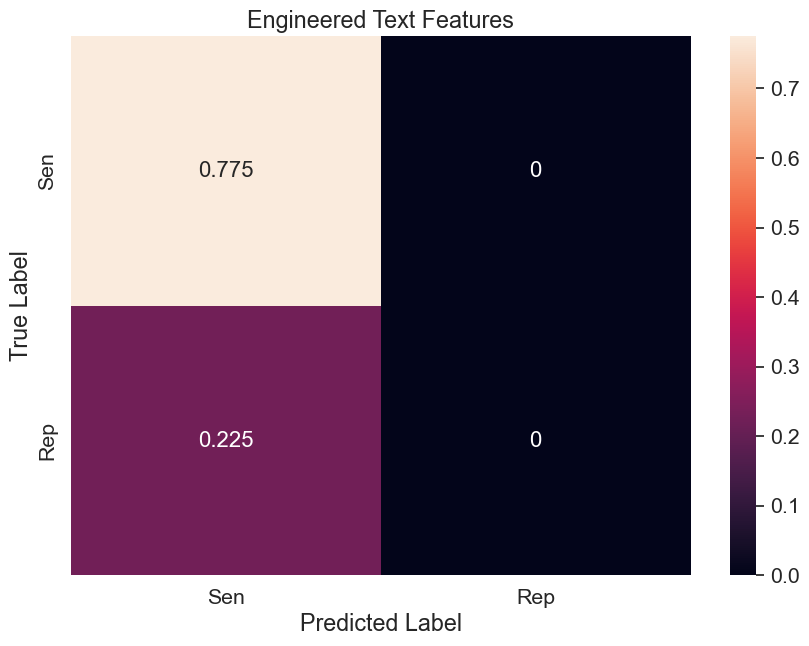

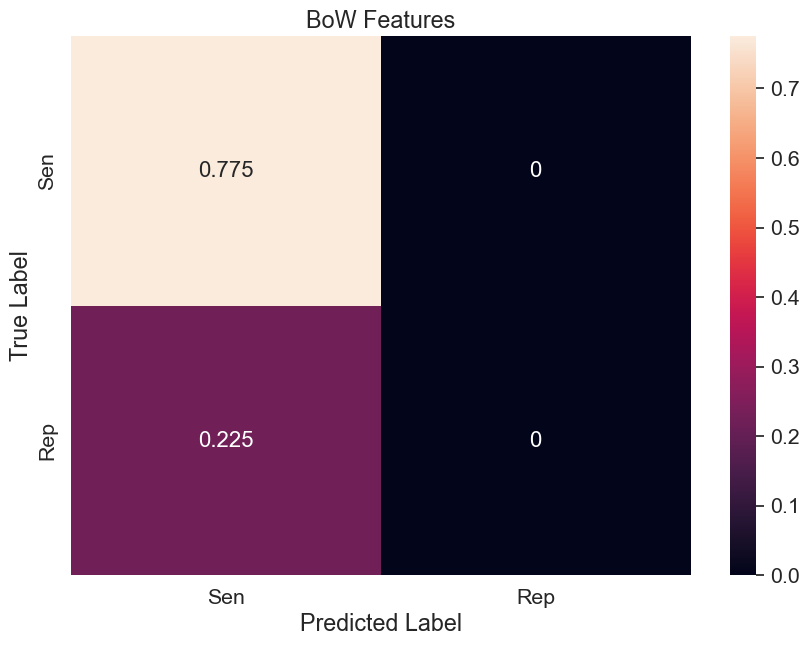

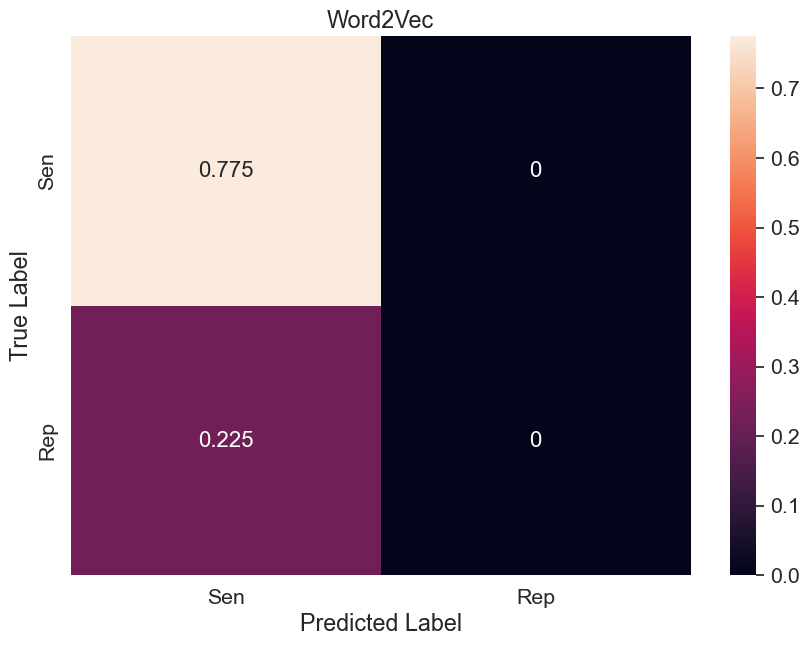

In [189]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "pred") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Sen", "Rep"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [130]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,polarity,tweet_len,word_count,position_binary
179232,1.192820e+18,RepJohnLarson,2019-11-08T09:51:47-05:00,"[wishing, radioviceonline, best, looking, forw...",John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",0.483333,337,50,1
495859,1.121510e+18,SenatorShaheen,2019-04-25T16:14:52-04:00,"[join, tomorrow, 615pm, berlin, town, hall, me...",Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918",0.000000,168,27,1
818005,1.273310e+18,JohnCornyn,2020-06-17T13:41:58-04:00,"[senatortimscott, y’all, wearing, kente, cloth...",John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",-0.208333,236,34,0
786850,1.185220e+18,JacksonLeeTX18,2019-10-18T11:47:17-04:00,"[senwhitehouse, choice, trump, gave, abandon, ...",Sheila Jackson Lee,Rep,3-Jan-95,1/12/1950,F,TX,18,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",-0.041667,247,36,1
548703,1.080880e+18,NitaLowey,2019-01-03T12:17:30-05:00,"[nancypelosi, house, representatives, opens, 1...",Nita Lowey,Rep,3-Jan-89,7/5/1937,F,NY,17,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",0.136364,164,28,1


In [162]:
# model initalization and fit
# --------

mask = np.array(congress_tweets["party"] != "Independent")

ct = pd.DataFrame(congress_tweets[mask])

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = ct['party_binary'] = lb_style.fit_transform(ct["party"])

dfs = [
    engineered_features[mask],
    dictionary_dataframe[mask],
    pd.DataFrame(doc_average_embeddings)[mask],
]

names = [
    "Engineered Features",
    "BoW",
    "Word2Vec",
]

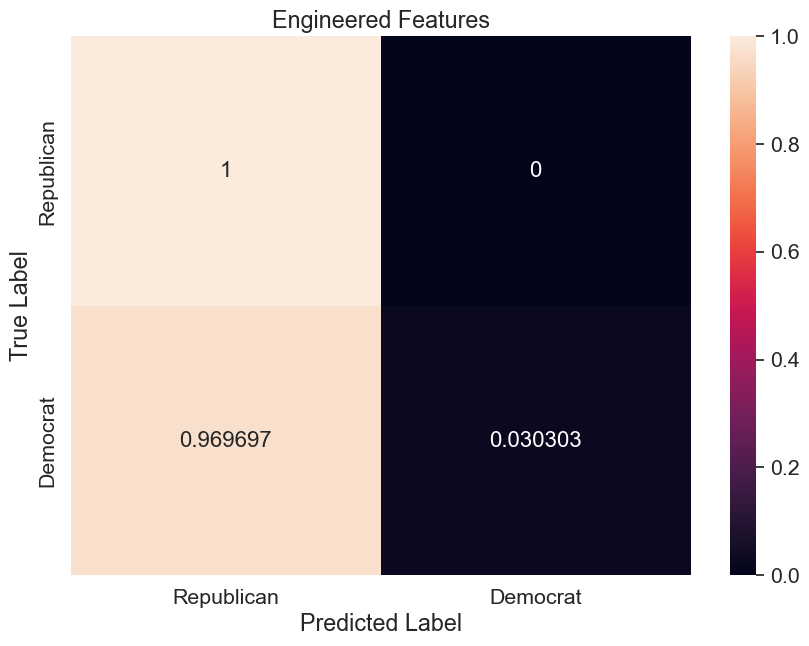

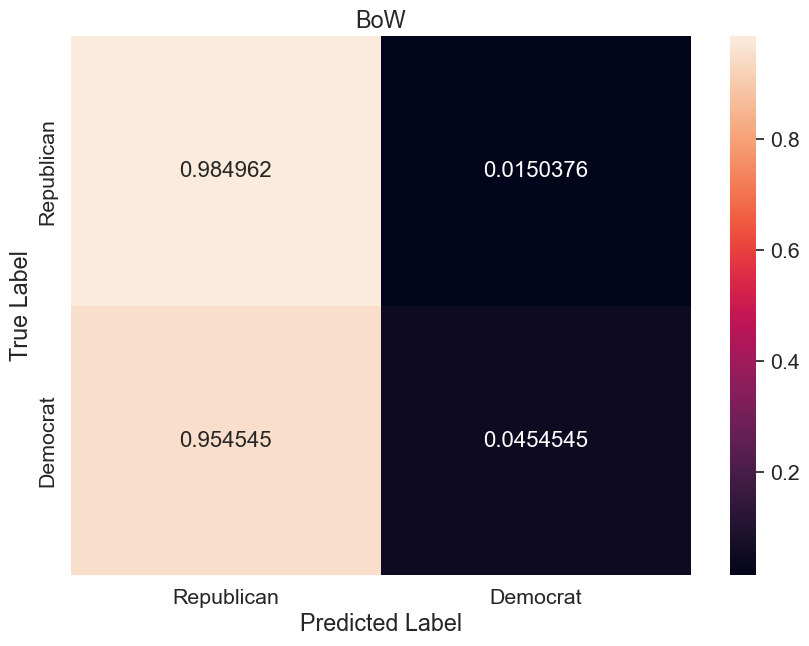

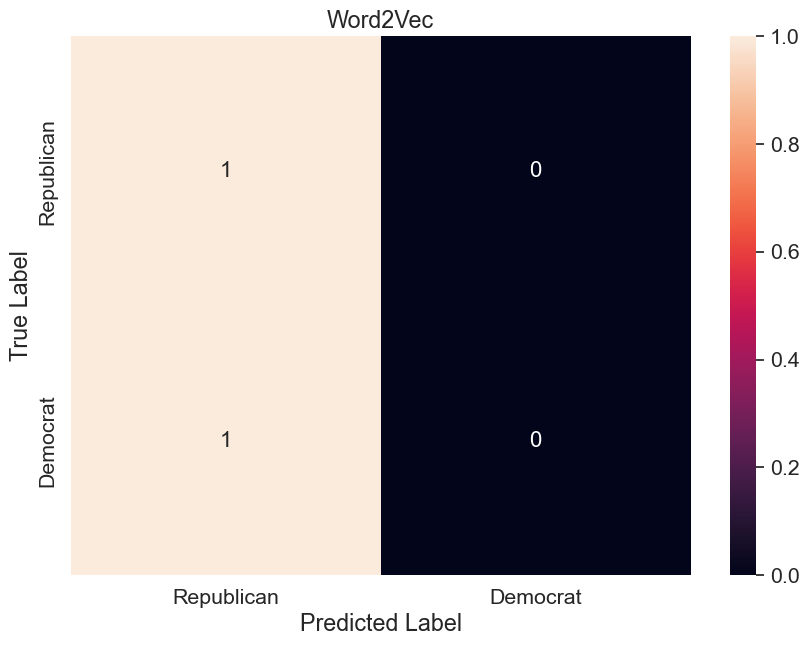

In [163]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dfs, names):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 

    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Republican", 
                                  1: "Democrat"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Republican", "Democrat"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [191]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# Non-text features
# --------
# select non-text features
non_text_features = congress_tweets[[  
    'state',
    'district_number',
    'trump_2016_state_share',
    'clinton_2016_state_share', 
    'obama_2012_state_share',
    'romney_2012_state_share',]]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)


In [192]:
# combine non-text features + BoW

non_text_BoW_features = non_text_features_dummies.reset_index(drop = True).join(dictionary_dataframe)


In [193]:
# create a list of dataframes from the objects created above
dataframes = [
              non_text_features_dummies,
              non_text_BoW_features]


# create a list of labeles based on the objects created above
featurization_technique = [
                           'Non-Text Features',
                           'Non-Text + BoW',
                           ]


In [194]:
len(non_text_features_dummies)

1000

In [195]:
len(non_text_BoW_features)

1000

In [196]:
len(congress_tweets)

1000

In [197]:
len(y)

1000

In [198]:
# model initalization and fit
# --------

# initalize binarizer
lb_style = LabelBinarizer()

# fit LabelBinarizer to our data
y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

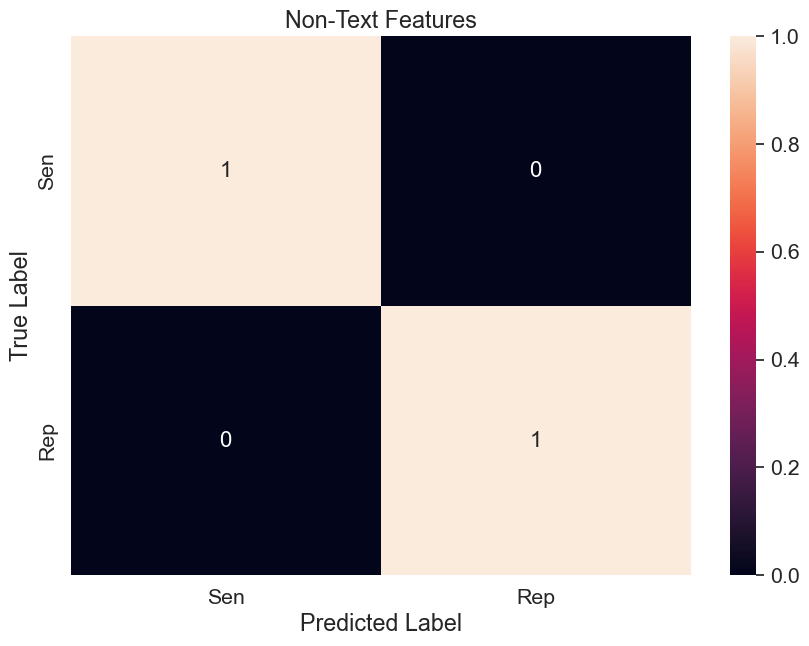

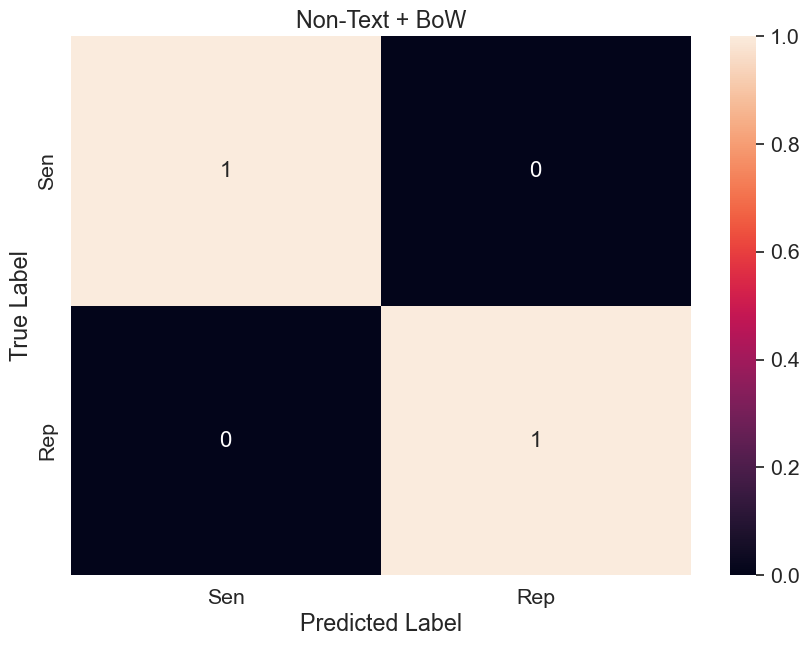

In [199]:
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# --------
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    # changing column names to strings because some are integer
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=0.20,    # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    # apply Logit model 
    # ----------
    # initalize Logit model 
    logit_reg = LogisticRegression() # set max_iter = 500

    # fit the model to our data
    logit_model = logit_reg.fit(X_train,         # specify feature data
                                y_train.ravel()) # specify label data --- don't forget to ravel the label dataset

    # predict on test set
    y_pred = logit_model.predict(X_test)
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "pred") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Sen", 
                                  1: "Rep"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Sen", "Rep"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Each corpus may have it's own domain-specific vocabulary, or jargon that may not be in the standard preprocessing techniques. It may also have special characters, for example, our corpus of tweets contained a lot of links, so removing those links required special attention. Language differences may also apply. Taking these factors into account when customizing preprocessing techniques can optimize NLP performance.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

When examining Democratic congressperson Nancy Pelosi's tweets compared to a Republican congressperson, Pelosi's tweets scored lower on polarity. Between Senators and Representatives, there does not seem to be much difference besides Representatives having more variance.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

Supervised learning approaches can tell the researcher how/if patterns from the unsupervised methods capture topics of interest. Unsupervised learning approaches do not take the meaning of words into account. Using supervised learning can help make your results relevant to your research questions.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The non-text and text w/ non-text performed the best. This indicates that the non-text features were highly predictive of the outcomes we were trying to predict-- this makes sense, given that the non-text features here were very political. The intuition behind combining text and non-text features is that there is valuable information in both that are unique.